In [28]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
from stimulus_presentation import ssvep
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# SSVEP

The steady-state visual evoked potential (SSVEP) is a repetitive evoked potential that is naturally produced when viewing stimuli flashing between a range of 6-75hz. Electrical activity at the same frequency as the visual stimulation can be detected in the occipital areas of the brain, likely due to the perceptual recreation of the stimulus in the primary visual cortex.

The SSVEP is often used in BCI applications due to its ease of detection and the amount of information that a user can communicate due to the high potential frequency resolution of the SSVEP.

In this notebook, we will use the Muse EEG headband with an extra occipital electrode to detect the SSVEP and evaluate it's use in SSVEP-based BCIs.


<img src="https://eeg-notebooks.readthedocs.io/en/latest/_images/attaching_electrode.png" style="height: 300px; float: right"/>
## Extra Electrode

Although the SSVEP is detectable at the default temporal electrodes, it can be seen much more clearly directly over the occipital cortex.

The Muse 2016 supports the addition of an extra electrode which can be connected through the devices microUSB charging port.

- [Instructions on how to build an extra electrode for Muse](http://forum.choosemuse.com/t/step-by-step-tutorial-for-making-muse-auxilliary-channel-electrode/3172?u=tttz)
- [Working with the extra electrode](https://eeg-notebooks.readthedocs.io/en/latest/using_an_extra_electrode_muse.html)

For this experiment, the extra electrode should be placed at POz, right at the back of the skull. It can be secured in place with a bandana or a hat


## Step 1: Connect to an EEG Device

*Note: if using Windows 10 and BlueMuse, skip this section and connect using the BlueMuse GUI*

Make sure your device is turned on and run the following code. It should detect and connect to the device and begin 'Streaming...'

If the device is not found or the connection times out, try running this code again

In [29]:
# Search for available Muse devices
muses = list_muses()

Searching for Muses, this may take up to 10 seconds...
Found device Muse-6BF0, MAC Address 00:55:DA:B0:6B:F0


In [30]:
# Start a background process that will stream data from the first available Muse
stream_process = Process(target=stream, args=(muses[0]['address'],))
stream_process.start()

Connecting to Muse : 00:55:DA:B0:6B:F0...
Connected.
Streaming...
missing sample 0 : 65535


## Step 2: Apply the EEG Device and Wait for Signal Quality to Stabilize
Once your Muse is connected and streaming data, put it on and run the following code to view the raw EEG data stream.

The numbers on the side of the graph indicate the variance of the signal. Wait until this decreases below 10 for all electrodes before proceeding.

*Note: the extra electrode's data is included in the stream as the 'Right Aux' Channel*

In [31]:
%matplotlib
view()

Using matplotlib backend: Qt5Agg
Looking for an EEG stream...
Start acquiring data.

                toggle filter : d
                toogle full screen : f
                zoom out : /
                zoom in : *
                increase time scale : -
                decrease time scale : +
               


## Step 3: Run the Experiment
Modify the variables in the following code chunk to define how long you want to run the experiment and the name of the subject and session you are collecting data from.

In [45]:
# Define these parameters 
duration = 120 # in seconds. 120 is recommended
subject = 1 # unique id for each participant
session = 1 # represents a data collection session. Multiple trials can be performed for each session

Seat the subject in front of the computer and run the following cell to run a single trial of the experiment.

In order to maximise the possibility of success, participants should take the experiment in a quiet environment and do their best to minimize movement that might contaminate the signal. With their jaw and face relaxed, subjects should look directly at the flashing stimuli.

Data will be recorded into CSV files in the `eeg-notebooks/data` directory

In [46]:
recording_path = os.path.join(os.path.expanduser("~"), "eeg-notebooks", "data", "visual", "SSVEP", "subject" + str(subject), "session" + str(session), ("recording_%s.csv" %
                                              strftime("%Y-%m-%d-%H.%M.%S", gmtime())) + ".csv")

stimulus = Process(target=ssvep.present, args=(duration,))
recording = Process(target=record, args=(duration, recording_path))

stimulus.start()
recording.start()

Looking for an EEG stream...
Started acquiring data.
Looking for a Markers stream...
Flickering frequencies (Hz): [30.0, 20.0]

Start recording at time t=1532444633.838
Time correction:  -2.2330499632516876e-05
5720.7450 	WARNING 	User requested fullscreen with size [1600  900], but screen is actually [1920, 1080]. Using actual size


### Repeat Data Collection 3-6 times

The SSVEP is a very prominent signal, but visualizing it can sometimes take many rounds of stimulus presentation. Depending on experimental conditions, this may require as little as one two minute trial or as many as 6. We recommend repeating the above experiment 3-6 times before proceeding. 

Make sure to take breaks, though! Inattention, fatigue, and distraction will decrease the quality of potentials such as the SSVEP

## Step 4: Prepare the Data for Analysis

Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the N170


### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step to using MNE is to read the data we've collected into an MNE `Raw` object

In [66]:
raw = utils.load_data('visual/SSVEP', sfreq=256., 
                      subject_nb=subject, session_nb=session,
                      ch_ind=[0, 1, 2, 3, 4], 
                      replace_ch_names={'Right AUX': 'POz'})

Creating RawArray with float64 data, n_channels=6, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=6, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.


### Power Spectral Density

One way to analyze the SSVEP is to plot the power spectral density, or PSD. SSVEPs should appear as peaks in power for certain frequencies. We expect clear peaks in the spectral domain at the stimulation frequencies of 30 and 20 Hz.

Effective window size : 8.000 (s)


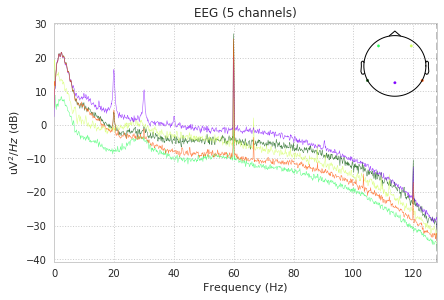

In [67]:
%matplotlib inline
raw.plot_psd();

We can clearly see some peaks in the EEG at 20 and 30hz. The peaks are certainly strongest in the POz channel

### Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus.

*Note: we will not reject epochs here because the amplitude of the SSVEP at POz is so large it is difficult to separate from eye blinks*

In [68]:
events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}

epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False, picks=[0, 1, 2, 3, 4])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)


197 events found
Event IDs: [1 2]
sample drop %:  2.538071065989844


### Stimuli-Specific PSD

Next, we can compare the PSD of epochs specifically during 20hz and 30hz stimulus presentation

Effective window size : 4.016 (s)
Effective window size : 4.016 (s)


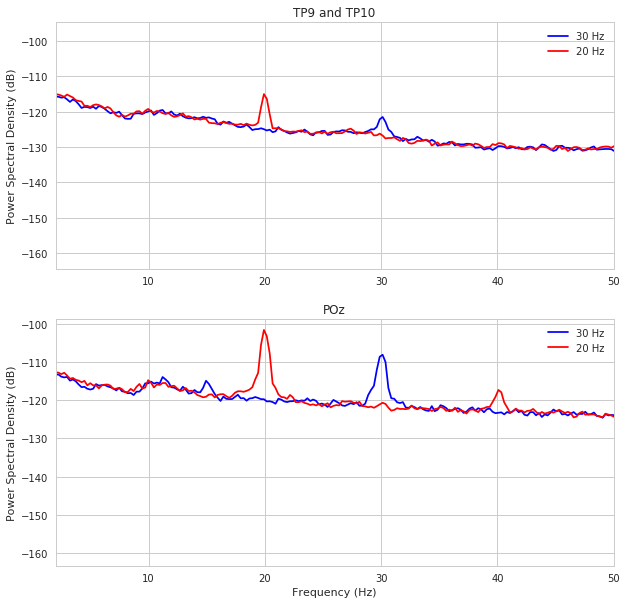

In [69]:
from mne.time_frequency import psd_welch

f, axs = plt.subplots(2, 1, figsize=(10, 10))
psd1, freq1 = psd_welch(epochs['30 Hz'], n_fft=1028, n_per_seg=256 * 3)
psd2, freq2 = psd_welch(epochs['20 Hz'], n_fft=1028, n_per_seg=256 * 3)
psd1 = 10 * np.log10(psd1)
psd2 = 10 * np.log10(psd2)

psd1_mean = psd1.mean(0)
psd1_std = psd1.mean(0)

psd2_mean = psd2.mean(0)
psd2_std = psd2.mean(0)

axs[0].plot(freq1, psd1_mean[[0, 3], :].mean(0), color='b', label='30 Hz')
axs[0].plot(freq2, psd2_mean[[0, 3], :].mean(0), color='r', label='20 Hz')

axs[1].plot(freq1, psd1_mean[4, :], color='b', label='30 Hz')
axs[1].plot(freq2, psd2_mean[4, :], color='r', label='20 Hz')

axs[0].set_title('TP9 and TP10')
axs[1].set_title('POz')
axs[0].set_ylabel('Power Spectral Density (dB)')
axs[1].set_ylabel('Power Spectral Density (dB)')
axs[0].set_xlim((2, 50))
axs[1].set_xlim((2, 50))
axs[1].set_xlabel('Frequency (Hz)')
axs[0].legend()
axs[1].legend()

plt.show();

With this visualization we can clearly see distinct peaks at 30hz and 20hz in the PSD, corresponding to the frequency of the visual stimulation. The peaks are much larger at the POz electrode, but still visible at TP9 and TP10

### Spectrogram
We can also look for SSVEPs in the spectrogram, which uses color to represent the power of frequencies in the EEG signal over time

Applying baseline correction (mode: logratio)


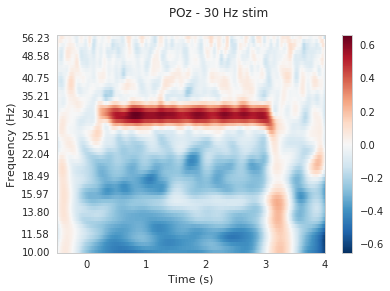

Applying baseline correction (mode: logratio)


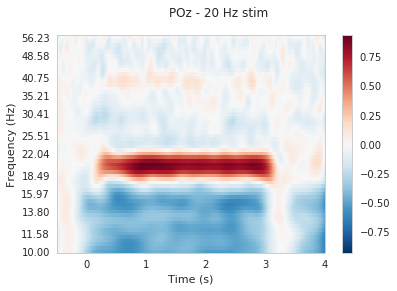

In [70]:
from mne.time_frequency import tfr_morlet

frequencies = np.logspace(1, 1.75, 60)
tfr, itc = tfr_morlet(epochs['30 Hz'], freqs=frequencies, 
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - 30 Hz stim');

tfr, itc = tfr_morlet(epochs['20 Hz'], freqs=frequencies, 
                      n_cycles=15, return_itc=True)
tfr.plot(picks=[4], baseline=(-0.5, -0.1), mode='logratio', 
         title='POz - 20 Hz stim');

Once again we can see clear SSVEPs at 30hz and 20hz

### Decoding

We can use a filter bank approach on the original 4 Muse electrodes (to see how the headband alone without external electrodes could be used to classify SSVEP):

1. Apply bandpass filters around both stimulation frequencies
2. Concatenate bandpass-filtered channels
2. Extract epochs (from 1 to 3 s after stimulus onset, to avoid classifying the ERP)
3. Apply common classification pipelines

In [71]:
# Bandpass filter the raw data
muse_raw = raw.drop_channels(['POz'])
raw_filt_30Hz = muse_raw.copy().filter(25, 35, method='iir')
raw_filt_20Hz = muse_raw.copy().filter(15, 25, method='iir')
raw_filt_30Hz.rename_channels(lambda x: x + '_30Hz')
raw_filt_20Hz.rename_channels(lambda x: x + '_20Hz')

# Concatenate with the bandpass filtered channels
raw_all = raw_filt_30Hz.add_channels([raw_filt_20Hz], 
                                    force_update_info=True)

# Extract epochs
events = find_events(raw_all)
event_id = {'30 Hz': 1, '20 Hz': 2}

epochs_all = Epochs(raw_all, events=events, event_id=event_id, tmin=1, 
                     tmax=3, baseline=None, reject={'eeg': 100e-6}, 
                     preload=True, verbose=False,)

Setting up band-pass filter from 25 - 35 Hz
Setting up band-pass filter from 25 - 35 Hz
Setting up band-pass filter from 25 - 35 Hz
Setting up band-pass filter from 25 - 35 Hz
Setting up band-pass filter from 25 - 35 Hz
Setting up band-pass filter from 25 - 35 Hz
Setting up band-pass filter from 15 - 25 Hz
Setting up band-pass filter from 15 - 25 Hz
Setting up band-pass filter from 15 - 25 Hz
Setting up band-pass filter from 15 - 25 Hz
Setting up band-pass filter from 15 - 25 Hz
Setting up band-pass filter from 15 - 25 Hz
197 events found
Event IDs: [1 2]
197 events found
Event IDs: [1 2]
Some events are duplicated in your different stim channels. 197 events were ignored during deduplication.


In [72]:
epochs_all.pick_types(eeg=True)
X = epochs_all.get_data() * 1e6
times = epochs.times
y = epochs_all.events[:, -1]

### Decoding the N170

Next, we will use 4 different machine learning pipelines to classify the SSVEP based on the data we collected. The 

- **CSP + RegLDA** :  Common Spatial Patterns + Regularized Linear Discriminat Analysis. This is a very common EEG analysis pipeline.
- **Cov + TS** :  Covariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipelines.
- **Cov + MDM**: Covariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.
- **CSP + Cov + TS**: Common Spatial Patterns + Covariance + Tangent spacem mapping. Riemannian pipeline with the standard CSP procedure beforehand

Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

*Note: because we're doing machine learning here, the following cell may take a while to complete*

In [75]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict

clfs = OrderedDict()

clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

CSP + RegLDA
Cov + TS
Cov + MDM
CSP + Cov + TS


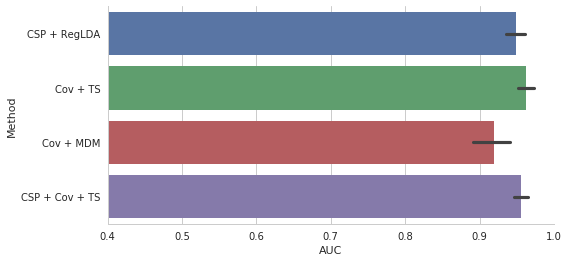

In [74]:
fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 1)
sns.despine()

The different classifiers get some impressive accuracy on this dataset, all around .95 AUC. This is impressive considering this pipeline only included data from the temporal electrodes

## Step 6: Share your Data!

How did your experiment go? If you're excited by your results we'd love to see your data!

Follow the instructions on our [Contributions](https://github.com/NeuroTechX/eeg-notebooks/blob/master/CONTRIBUTING.md) page to make a pull request with your data and we'll review it to be added to the EEG notebooks project.